# CRSP: various topics (Nasdaq stocks; number of stocks and common shares; pitfalls learned so far)

&copy; **Johannes Ruf** (comments welcome under j.ruf@lse.ac.uk, February 2023)

In [41]:
import pandas as pd

import seaborn
seaborn.set()

import wrds
wrds_login = 'xxx'    # update to your login info on CRSP

pd.set_option('display.max_columns', None)

In [2]:
db = wrds.Connection(wrds_username=wrds_login)

Loading library list...
Done


## Nasdaq information

 A security that is traded on NASDAQ has the `primaryexch` flag set to `Q` (this flag is provided in the tables `stocknames_v2` and `StkSecurityInfoHist`). Other primary exchanges and their flag values are described [here](https://www.crsp.org/files/appendix/FlagType_EC.html). Google is an example for a security traded on NASDAQ.

If a stock has NASDAQ as primary exchange then CRSP provides additional information in the tables `StkSecurityInfoHist`, `StkIssuerInfoHist` (see previous notebook), and in price tables, e.g., `dsf_v2`.   

An example is the flag `exchangetier` in `StkSecurityInfoHist`, which specifies the NASDAQ market tier (see the [NASDAQ website](https://www.nasdaq.com/solutions/nasdaq-stock-market-tiers)).

Two potentially quite interesting features are contained in the price files, e.g., `StkDlySecurityData`. The first one is `dlymmcnt` (the number of registered market makers). The second one is `dlynumtrd`, the number of trades made for each trading day, for the specific security.

In [3]:
googleC_permno = 14542

In [4]:
google = db.raw_sql("SELECT * FROM crsp.StkDlySecurityData WHERE permno = {}".format(googleC_permno), date_cols='dlycaldt')
google = google.set_index('dlycaldt')

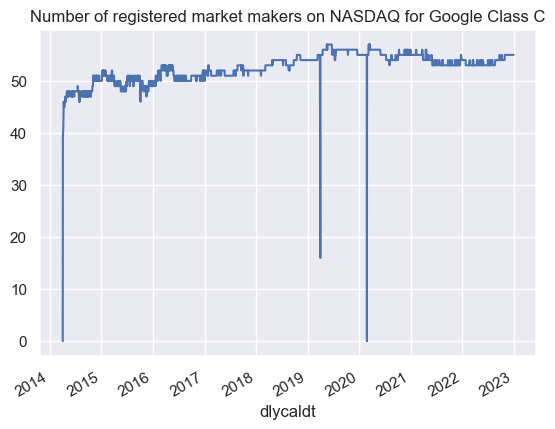

In [5]:
google['dlymmcnt'].plot(title='Number of registered market makers on NASDAQ for Google Class C');

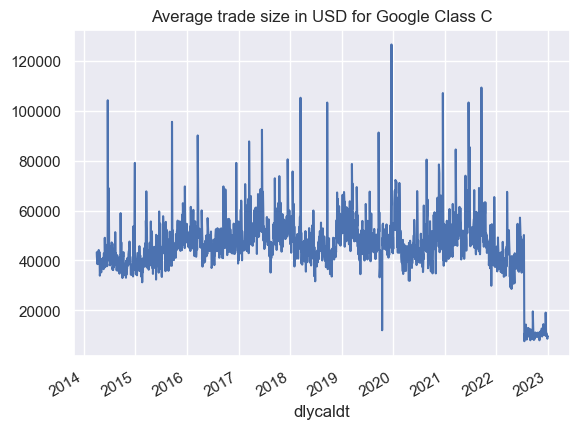

In [6]:
(google['dlyprcvol'] / google['dlynumtrd']).plot(title='Average trade size in USD for Google Class C');

## Number of assets traded and common shares

Let's first check how many stocks CRSP lists at any point of time.

In [7]:
%%time

n_of_assets_raw = db.raw_sql("""
                SELECT dlycaldt, COUNT(*) AS nobs FROM crsp.StkDlySecurityPrimaryData GROUP BY dlycaldt
                """, date_cols='dlycaldt')
n_of_assets_raw = n_of_assets_raw.set_index('dlycaldt')

CPU times: user 110 ms, sys: 43.9 ms, total: 154 ms
Wall time: 30.1 s


In [8]:
print('Minimum # of assets (raw): {}; Maximum # of assets (raw): {}'.
     format(n_of_assets_raw['nobs'].min(), n_of_assets_raw['nobs'].max()))

Minimum # of assets (raw): 509; Maximum # of assets (raw): 9602


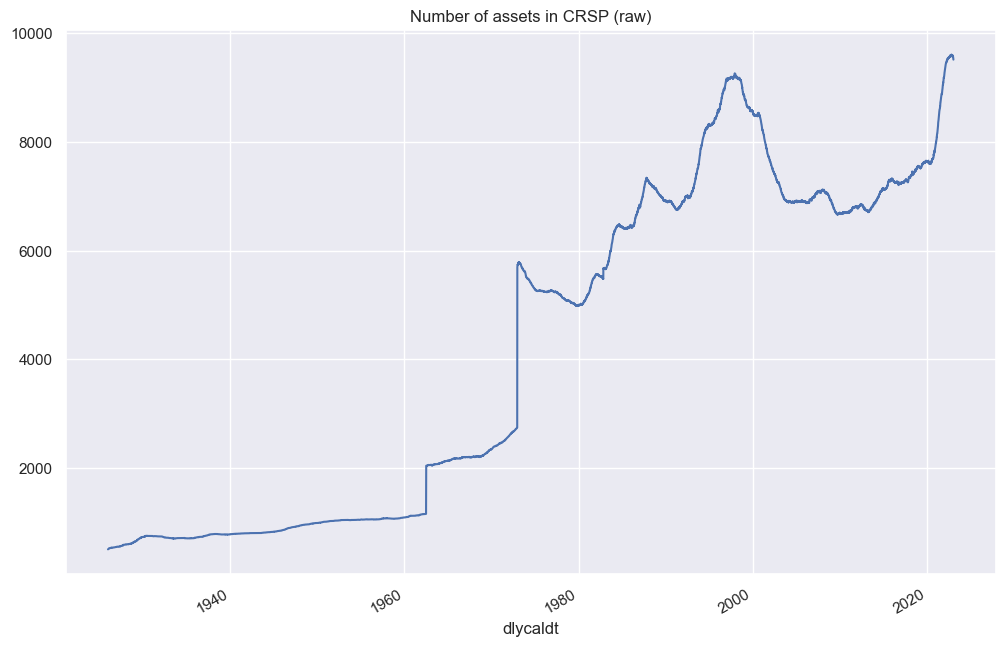

In [9]:
n_of_assets_raw.plot(title='Number of assets in CRSP (raw)', figsize=(12, 8), legend=False);

CRSP contains a lot of shares that are not *common shares*.  For example, [REITs](https://en.wikipedia.org/wiki/Real_estate_investment_trust) or [ADRs](https://en.wikipedia.org/wiki/American_depositary_receipt).  All of those are included in the above plot.

The legacy tables provided a flag `shrcd`. Common stocks referred to the values `10` and `11`. In many empirical finance papers this flat will be explicitly mentioned. In the new CRSP version, it's a bit more difficult to check for common stocks. The mapping [here](https://www.crsp.org/files/ShareCode.html) describes what should be done.

The relevant information is contained in the event table `StkSecurityInfoHist`.

In [10]:
%%time

security_info = db.raw_sql("select * from crsp.StkSecurityInfoHist")

CPU times: user 2.75 s, sys: 1.04 s, total: 3.79 s
Wall time: 11.9 s


In [11]:
security_info.head()

,permno,secinfostartdt,secinfoenddt,securitybegdt,securityenddt,securityhdrflg,hdrcusip,hdrcusip9,cusip,cusip9,primaryexch,conditionaltype,exchangetier,tradingstatusflg,securitynm,shareclass,usincflg,issuertype,securitytype,securitysubtype,sharetype,securityactiveflg,delactiontype,delstatustype,delreasontype,delpaymenttype,ticker,tradingsymbol,permco,siccd,naics,icbindustry,nasdcompno,nasdissuno,issuernm
0,10000.0,1986-01-07,1986-12-03,1986-01-07,1987-06-11,N,68391610,683916100,68391610,683916100,Q,RW,SC1,A,OPTIMUM MANUFACTURING INC; COM A; CONS,A,Y,ACOR,EQTY,COM,NS,Y,GDR,VCL,INSC,PRCF,OMFGA,OMFGA,7952.0,3990.0,None,NOAVAIL,60007905.0,10396.0,OPTIMUM MANUFACTURING INC
1,10000.0,1986-12-04,1987-03-09,1986-01-07,1987-06-11,N,68391610,683916100,68391610,683916100,Q,RW,SC1,A,OPTIMUM MANUFACTURING INC; COM A; CONS,A,Y,ACOR,EQTY,COM,NS,Y,GDR,VCL,INSC,PRCF,OMFGA,OMFAC,7952.0,3990.0,None,NOAVAIL,60007905.0,10396.0,OPTIMUM MANUFACTURING INC
2,10000.0,1987-03-10,1987-06-11,1986-01-07,1987-06-11,Y,68391610,683916100,68391610,683916100,Q,RW,SC1,A,OPTIMUM MANUFACTURING INC; COM A; CONS,A,Y,ACOR,EQTY,COM,NS,Y,GDR,VCL,INSC,PRCF,OMFGA,OMFGA,7952.0,3990.0,None,NOAVAIL,60007905.0,10396.0,OPTIMUM MANUFACTURING INC
3,10000.0,1987-06-12,1987-06-12,1986-01-07,1987-06-11,N,68391610,683916100,None,None,X,N/A,N/A,D,OPTIMUM MANUFACTURING INC (LAST KNOWN); COM A;...,None,N,N/A,N/A,UNK,N/A,N,N/A,N/A,N/A,N/A,None,None,7952.0,NaN,None,NOAVAIL,60007905.0,0.0,OPTIMUM MANUFACTURING INC (Last Known)
4,10001.0,1986-01-09,1986-09-01,1986-01-09,2017-08-03,N,36720410,367204104,39040610,390406106,Q,RW,SC1,A,GREAT FALLS GAS CO; COM NONE; CONS,None,Y,CORP,EQTY,COM,NS,Y,MER,FPAY,UNAV,CASH,GFGC,GFGC,7953.0,4920.0,None,NOAVAIL,60007906.0,10398.0,GREAT FALLS GAS CO


To be a common share, we will have to take that the following four conditions hold:

a) `sharetype` equals `NS` ('not specified', other types could be ADRs or certificates, for example);
b) `securitysubtype` equals `COM` (for `common`, other types could be closed-end funds, for example);
c) `issuertype` is either `ACOR` or `CORP` ((assumed) corporation; there is only one other type, namely REITs);
d) `usincflg` equals `Y` (US-incorporated).

There is another relevant column, namely `securitytype`, which describers whether the security is a stock, a derivative, or a fund. However, we don't have to check it since condition a) above already implies that `securitytype` always equals `EQTY`.

With this in place, we can now count how many common stocks there are at any specific date, as follows.

In [12]:
%%time

n_of_assets = db.raw_sql("""SELECT d.dlycaldt, COUNT(*) AS nobs FROM crsp.StkDlySecurityPrimaryData AS d
                            JOIN crsp.StkSecurityInfoHist AS i
                            ON d.permno = i.permno AND i.secinfostartdt <= d.dlycaldt 
                            AND d.dlycaldt <= i.secinfoenddt
                            WHERE i.sharetype = 'NS' AND i.securitysubtype = 'COM' 
                            AND i.issuertype IN ('ACOR','CORP') AND i.usincflg = 'Y'
                            GROUP BY d.dlycaldt
                          """, date_cols='dlycaldt')

n_of_assets = n_of_assets.set_index('dlycaldt')

CPU times: user 46.9 ms, sys: 34.4 ms, total: 81.3 ms
Wall time: 24.6 s


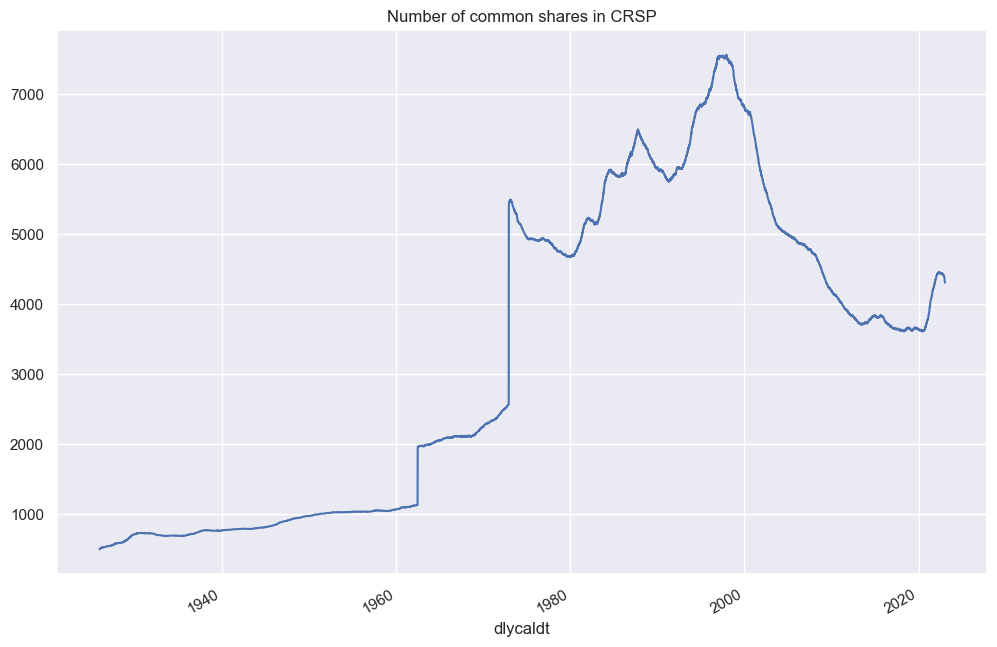

In [13]:
n_of_assets.plot(title='Number of common shares in CRSP', figsize=(12, 8), legend=False);

In [14]:
print('Minimum # of assets: {}; Maximum # of assets: {}'.
     format(n_of_assets['nobs'].min(), n_of_assets['nobs'].max()))

Minimum # of assets: 497; Maximum # of assets: 7563


**Observations:**

 * The numbers of assets of type *common shares* go up and then down again. 
 * In particular, we do not see the recent increase in number of listed securities as above (which is driven, for example, by including more foreign incorporated companies).
 * Some of the observed increases are *technical* due to changes in CRSP:
  * At the beginning, CRSP only contains NYSE data.
  * Beginning Jul 2, 1962, CRSP also contains [NYSE American](https://en.wikipedia.org/wiki/NYSE_American).
  * Beginning Dec 14, 1972, CRSP also includes NASDAQ.
  * Beginning Mar 8, 2006, CRSP also includes NYSE ARCA (only increases the number of common shares by 6).

**Additional reading:** I put a brief FT article on the cloud that discusses the topic of the decreasing number of traded assets.

**Attention:**  When building an investment universe according to rules a)-d) above, a security might fall out of the universe if it stops satisfying one of the rules a)-d); for example, if it changes from US incorporated to foreign incorporated.  In this case, the security is not necessarily being delisted within CRSP but only falls out of  our subset of investable securities.

**A major warning:** On the day when a security is being delisted it does not satisfy rules a)-d). Thus when building an investment universe according to rules a)-d) we must make sure that we include the delisting days. The following is  a (typical) example:

In [15]:
permno = 10002
info = db.raw_sql("SELECT * FROM crsp.StkSecurityInfoHist WHERE permno = {}".format(permno), 
                  date_cols=['secinfostartdt'])
prc = db.raw_sql("SELECT * FROM crsp.StkDlySecurityData WHERE permno = {}".format(permno), 
                  date_cols=['dlycaldt'])

In [16]:
info[info['secinfostartdt'].dt.year >= 2008]

,permno,secinfostartdt,secinfoenddt,securitybegdt,securityenddt,securityhdrflg,hdrcusip,hdrcusip9,cusip,cusip9,primaryexch,conditionaltype,exchangetier,tradingstatusflg,securitynm,shareclass,usincflg,issuertype,securitytype,securitysubtype,sharetype,securityactiveflg,delactiontype,delstatustype,delreasontype,delpaymenttype,ticker,tradingsymbol,permco,siccd,naics,icbindustry,nasdcompno,nasdissuno,issuernm
9,10002.0,2008-06-27,2013-02-15,1986-01-10,2013-02-15,Y,05978R10,05978R107,05978R10,05978R107,Q,RW,S,A,BANCTRUST FINANCIAL GROUP INC; COM NONE; CONS,None,Y,CORP,EQTY,COM,NS,Y,MER,FPAY,UNAV,STK,BTFG,BTFG,7954.0,6020.0,551111,FINL,60007907.0,10399.0,BANCTRUST FINANCIAL GROUP INC
10,10002.0,2013-02-16,2013-02-19,1986-01-10,2013-02-15,N,05978R10,05978R107,None,None,X,N/A,N/A,D,BANCTRUST FINANCIAL GROUP INC (LAST KNOWN); CO...,None,N,N/A,N/A,UNK,N/A,N,N/A,N/A,N/A,N/A,None,None,7954.0,NaN,None,NOAVAIL,0.0,0.0,BANCTRUST FINANCIAL GROUP INC (Last Known)


In [17]:
prc[prc['dlycaldt'] > '2013-02-14']

,permno,yyyymmdd,dlycaldt,dlydelflg,dlyprc,dlyprcflg,dlycap,dlycapflg,dlyprevprc,dlyprevprcflg,dlyprevdt,dlyprevcap,dlyprevcapflg,dlyret,dlyretx,dlyreti,dlyretmissflg,dlyretdurflg,dlyorddivamt,dlynonorddivamt,dlyfacprc,dlydistretflg,dlyvol,dlyclose,dlylow,dlyhigh,dlybid,dlyask,dlyopen,dlynumtrd,dlymmcnt,dlyprcvol
6833,10002.0,20130215.0,2013-02-15,N,2.98,TR,53538.68,BP,2.92,TR,2013-02-14,52460.72,PB,0.020548,0.020548,0.0,NA,D1,0.0,0.0000,1.0,NO,2319.0,2.98,2.95,2.98,2.95,2.98,2.95,19.0,30.0,6910.62
6834,10002.0,20130219.0,2013-02-19,Y,0.00,DA,NaN,DE,2.98,TR,2013-02-15,53538.68,PB,0.010906,0.010906,0.0,NA,DD,0.0,3.0125,1.0,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that the delisting return, reported on February 19, 2013, would not be included in the above SQL query for `n_of_assets` since the WHERE conditions are not satisfied.

**A warning concerning the WRDS web interface**: If we did the same experiment with data downloaded from the WRDS website we would get a slightly different result (we would get a slightly smaller universe).  For example, the stock with `permno` 10388 would not pass the filter with the data obtained through the web interface (as of February 2023).  (Those data have the `usincflg` set to `N` for for the `permno` 10388, while `StkSecurityInfoHist` has the flag first at `Y` and only later at `N`.) As confirmed in a personal communication with WRDS, this is due to a wrong implementation on the WRDS website (where `StkSecurityInfoHdr` is used instead of `StkSecurityInfoHist`). According to WRDS, this mistake should be fixed by end of February 2023.

### Project

How many different companies (different common securities) are included in CRSP, in total?  How many common securities have been delisted?

#### A solution

In [18]:
permnos = db.raw_sql("""SELECT DISTINCT permno FROM crsp.StkSecurityInfoHist
                            WHERE sharetype = 'NS' AND securitysubtype = 'COM' 
                            AND issuertype IN ('ACOR','CORP') AND usincflg = 'Y'
                          """)

print('There were {} different common securities been in CRSP.'.format(len(permnos)))

There were 26501 different common securities been in CRSP.


In [19]:
n_today = n_of_assets['nobs'].iloc[-1]
n_delisted = len(permnos) - n_today
print('As of now, we have {} different common securities.'.format(n_today),
      'Hence {} common securities have been delisted.'.format(n_delisted))

As of now, we have 4307 different common securities. Hence 22194 common securities have been delisted.


### Check with legacy tables

Let's briefly check whether the number of common shares (`n_of_assets`) we obtained above is the same as we would have gotten with the legacy data when using `shrcd`.

In [20]:
%%time

n_legacy = db.raw_sql("""SELECT d.date, COUNT(*) as nobs FROM crsp.dsf AS d
                            JOIN crsp.dsenames AS n
                            ON d.permno=n.permno AND n.namedt <= d.date AND d.date <= n.nameendt
                            WHERE n.shrcd BETWEEN 10 AND 11
                            GROUP BY d.date
                          """, date_cols='date')
n_legacy = n_legacy.set_index('date')

CPU times: user 53.8 ms, sys: 44.6 ms, total: 98.4 ms
Wall time: 39.5 s


In [21]:
assert (n_of_assets - n_legacy).abs().max()[0] == 0

## Lessons and CRSP pitfalls learned so far

* Prices provided might rely on bid/ask averages only instead of traded closing prices. (Not being able to trade the corresponding securities might negatively impact trading strategies, but possibly won't be recognized when backtesting.) -> Check the corresponding price flag `dlyprcflg` in the table `StkDlySecurityData` (or `dsf_v2`).
* The same company have different outstanding share classes (different `permno`s).
* Computing market capitalizations and comparing them dynamically accross time might require adjustments (in the legacy tables this could be done via `cfacshr` and `cfacpr`). 
* CRSP includes several asset types that are not common shares. -> Needs careful selection of the investment universe.
* Return computations need to include dividends etc (something CRSP takes care of).
* Delistings occur frequently, but taking care of them is not always easy:
 * Missing data;
 * Monthly delisting returns might be missing but this is only reflected in the corresponding flags;
 * Temporary delistings;
 * Abnormal delisting returns;
 * Securities might fall out of our investment universe without being delisted (due to a change in status, for example);
 * On the day of delisting, the corresponding information in `StkSecurityInfoHist` does not exactly reflect whether the stock was in our investment universe or not. (See warning above and also Notebook 6.)
* The official CRSP documentation doesn't explain all flag values; see for example the warning for `dlyprcflg` in Notebook 2.

All of this sounds quite 'negative', but might not be too bad. But it is very important to be aware of these issues, either when critically reflecting on others' studies or when doing your own research.

Also, for many questions we don't need returns (e.g. for descriptive statistics of the US market like number of assets traded). To answer such questions the issue of delisting returns etc. won't matter too much.

## Project

Provide some additional descriptive statistics of the CRSP dataset, along the following pointers:

* What's the number of common shares on each of the exchanges? How did it evolve over time?
* How much money was invested at any point in common shares, and accross the different exchanges?

*Hints*: Google for `pandas` tricks and to understand CRSP fields.  Only use monthly data (to avoid timeouts by the WRDS connection, e.g. provided by `StkMthSecurityData`).  Moreover, this [flag description](https://www.crsp.org/files/appendix/FlagType_EC.html) might be helpful.

### A solution

The following code has a logical problem and introduces a small error:

In [22]:
%%time

df = db.raw_sql("""SELECT m.mthcaldt, m.primaryexch, m.mthcap FROM crsp.StkMthSecurityData AS m
                            JOIN crsp.StkSecurityInfoHist AS s
                            ON m.permno = s.permno AND s.secinfostartdt <= m.mthcaldt 
                            AND m.mthcaldt <= s.secinfoenddt
                            WHERE s.sharetype = 'NS' AND s.securitysubtype = 'COM' 
                            AND s.issuertype IN ('ACOR','CORP') AND s.usincflg = 'Y'
                          """, date_cols='mthcaldt')

df = df.set_index('mthcaldt')

CPU times: user 13.2 s, sys: 4.24 s, total: 17.5 s
Wall time: 39.9 s


Indeed, it turns out that some securities are delisted in the middle of a month. In this case, the last entry of a stock doesn't get included in `df` as `mthcaldt` (the end of the month) is then larger then `secinfoenddt`. 

Fortunately, an easy solution exists. The table `StkMthSecurityData` contains already all relevant features so that a join with `StkSecurityInfoHist` isn't necessary.  (The table `StkDlySecurityData`, however, does not contain these fields.) Hence, we can use the following code, which is simpler and also returns the correct number of common stocks traded in each month:

In [23]:
%%time

df = db.raw_sql("""SELECT mthcaldt, primaryexch, mthcap FROM crsp.StkMthSecurityData 
                            WHERE sharetype = 'NS' AND securitysubtype = 'COM' 
                            AND issuertype IN ('ACOR','CORP') AND usincflg = 'Y'
                          """, date_cols='mthcaldt')

df = df.set_index('mthcaldt')

CPU times: user 11.3 s, sys: 3.53 s, total: 14.8 s
Wall time: 40.2 s


In [24]:
len(df)

3791141

In [25]:
df = df[df['mthcap'].notnull()]
len(df)

3717515

In [26]:
df['primaryexch'].value_counts()

Q    1880312
N    1391393
A     444171
X       1127
R        437
B         63
I         12
Name: primaryexch, dtype: int64

In [27]:
df = df[df['primaryexch'] != 'X']
len(df)

3716388

In [28]:
exchange_dict = {'Q': 'NASDAQ', 'N': 'NYSE', 'A': 'NYSE American', 'R': 'Other', 'B': 'Other', 'I': 'Other'}

In [29]:
df['exchange'] = df['primaryexch'].replace(exchange_dict)

In [30]:
df_agg = df.groupby(['mthcaldt', 'exchange']).mthcap.aggregate(['count', 'sum']).unstack()

In [31]:
total = df.groupby('mthcaldt').mthcap.aggregate(['count', 'sum'])
df_agg['count', 'total'] = total['count']
df_agg['sum', 'total'] = total['sum']
df_agg = df_agg.sort_index(axis=1)

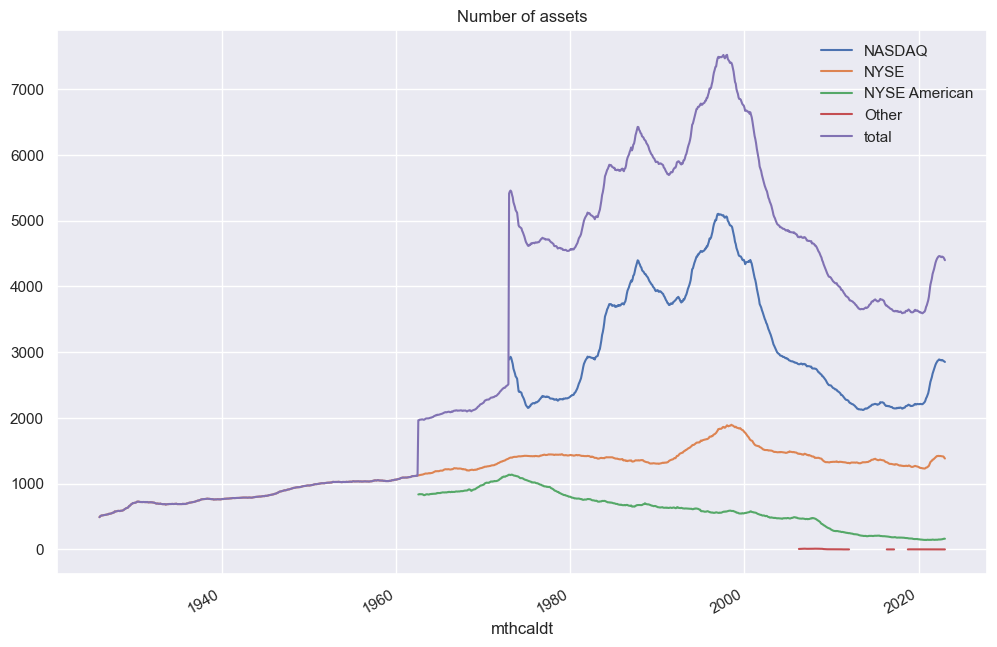

In [32]:
ax = df_agg['count'].plot(figsize=(12, 8), title='Number of assets')
ax.legend(frameon=False);

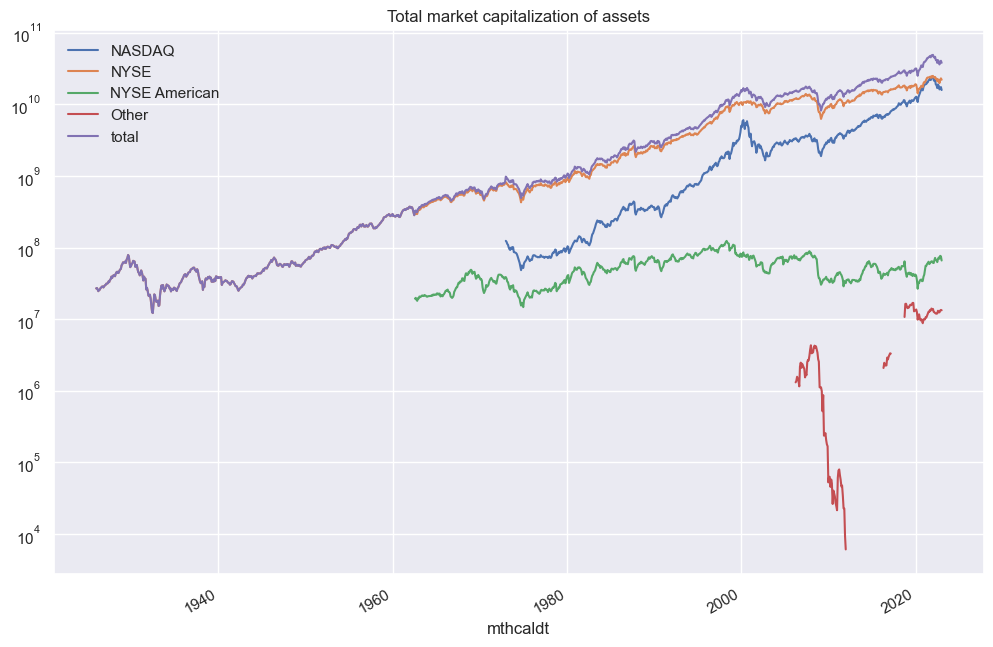

In [33]:
ax = df_agg['sum'].plot(logy=True, figsize=(12, 8), title='Total market capitalization of assets')
ax.legend(frameon=False);

## Project: percentage of stocks paying ordinary dividends

Study the percentage of securities that pay ordinary dividends, and how this percentage changes over time. More precisely, for each year plot the ratio of the number of securities (common shares) that pay ordinary dividends by the total number of securities (common shares). 

*Hint:* You might find the field `dlyorddivamt` in the `dsf_v2` table helpful.  To speed up the SQL queries you might consider to use, in addition, also `msf_v2`.

### A solution

We first obtain the number of securities (common shares) that pay dividends in each year.

In [34]:
%%time

dividends_df = db.raw_sql("""SELECT d.dlycaldt, d.permno FROM crsp.dsf_v2 AS d
                            JOIN crsp.StkSecurityInfoHist AS s
                            ON d.permno = s.permno AND s.secinfostartdt <= d.dlycaldt 
                            AND d.dlycaldt <= s.secinfoenddt
                            WHERE s.sharetype = 'NS' AND s.securitysubtype = 'COM' 
                            AND s.issuertype IN ('ACOR','CORP') AND s.usincflg = 'Y'
                            AND d.dlyorddivamt > 0
                          """, date_cols='dlycaldt')

CPU times: user 1.46 s, sys: 804 ms, total: 2.26 s
Wall time: 1min 29s


In [35]:
dividends_df['year'] = dividends_df['dlycaldt'].dt.year
dividends_df = dividends_df.drop('dlycaldt', axis=1).drop_duplicates()
n_of_divs = dividends_df.groupby('year')['permno'].count()

We next obtain the number permnos representing common shares for each year. We could have used the one SQL query above to obtain also this information but it's much faster to use `msf_v2`:

In [36]:
%%time

permnos = db.raw_sql("""SELECT m.mthcaldt, m.permno FROM crsp.msf_v2 AS m
                            JOIN crsp.StkSecurityInfoHist AS s
                            ON m.permno = s.permno AND s.secinfostartdt <= m.mthcaldt 
                            AND m.mthcaldt <= s.secinfoenddt
                            WHERE s.sharetype = 'NS' AND s.securitysubtype = 'COM' 
                            AND s.issuertype IN ('ACOR','CORP') AND s.usincflg = 'Y'
                          """, date_cols='mthcaldt')

CPU times: user 11.3 s, sys: 3.14 s, total: 14.5 s
Wall time: 31.8 s


In [37]:
permnos['year'] = permnos['mthcaldt'].dt.year
permnos = permnos.drop('mthcaldt', axis=1).drop_duplicates()
n_of_permnos = permnos.groupby('year')['permno'].count().loc['1926':]

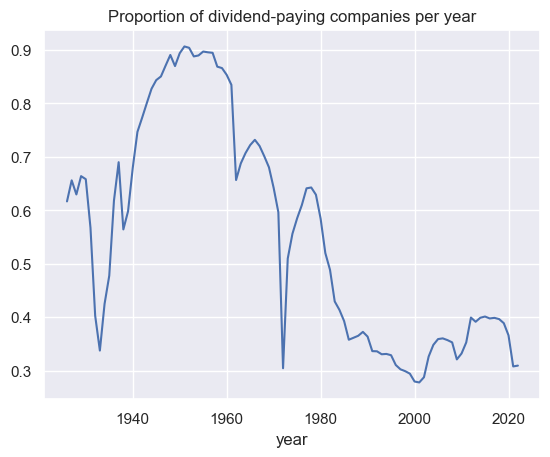

In [38]:
(n_of_divs / n_of_permnos).loc['1926':].plot(title='Proportion of dividend-paying companies per year');

In [39]:
db.close()

In [40]:
%reset -f